In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
import joblib

# Ensure NLTK resources are available
nltk_data_path = os.path.join(os.path.expanduser('~'), 'nltk_data')
if os.path.exists(os.path.join(nltk_data_path, 'corpora', 'wordnet')):
    try:
        nltk.data.find('corpora/wordnet')
    except:
        print('Clearing corrupted WordNet data...')
        os.system(f'rm -rf {os.path.join(nltk_data_path, "corpora", "wordnet")}')
        nltk.download('wordnet', quiet=True)
else:
    nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)

print('NLTK resources ready.')

NLTK resources ready.


In [2]:
df = pd.read_csv('data/dataset.csv', delimiter='\t', header=None, names=['label', 'message'])
print("Dataset Loaded Successfully")


Dataset Loaded Successfully


In [3]:
print("=== Dataset Overview ===")
print(f"Shape: {df.shape}")
print(df.info())
print(df.head())


=== Dataset Overview ===
Shape: (5572, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [4]:
print("\n=== Missing Values ===")
print(df.isnull().sum())



=== Missing Values ===
label      0
message    0
dtype: int64



=== Spam vs Ham Distribution ===
label
ham     4825
spam     747
Name: count, dtype: int64


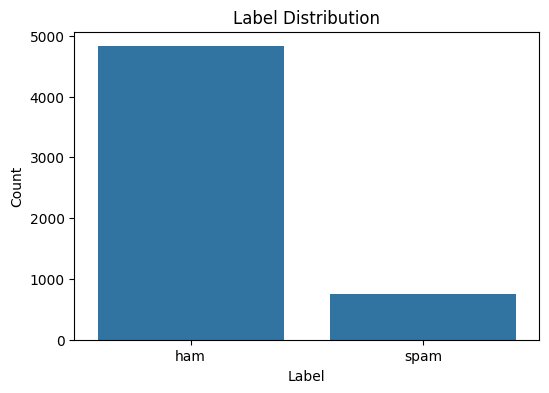

In [5]:
print("\n=== Spam vs Ham Distribution ===")
print(df['label'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.savefig('label_distribution.png')
plt.show()


In [6]:
# Use basic stopwords list if nltk resources can't be downloaded
try:
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'but'}
    lemmatizer = WordNetLemmatizer()
except:
    stop_words = set([
        'i', 'me', 'my', 'myself', 'we', 'our', 'you', 'he', 'she', 'it',
        'they', 'them', 'this', 'that', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 
        'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 
        'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off'
    ])
    lemmatizer = lambda x: x  # dummy

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|@\w+|#\w+|[^a-z\s]', '', text)
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)


In [7]:
df['cleaned_text'] = df['message'].apply(lambda x: preprocess_text(str(x)))


In [8]:

# Cell 4: Text Vectorization
def vectorize_text(X_train, X_test):
    start = time.time()
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=20000,
        ngram_range=(1, 3),
        min_df=2
    )
    X_train_vect = vectorizer.fit_transform(X_train).astype(np.float32)
    X_test_vect = vectorizer.transform(X_test).astype(np.float32)
    logger.info(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
    log_time("Text vectorization", start)
    return vectorizer, X_train_vect, X_test_vect

In [9]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])


In [10]:
df['text_length'] = df['message'].apply(lambda x: len(str(x).split()))
print(f"Average Words per Message: {df['text_length'].mean():.2f}")
print(f"Max Words: {df['text_length'].max()}, Min Words: {df['text_length'].min()}")


Average Words per Message: 15.60
Max Words: 171, Min Words: 1


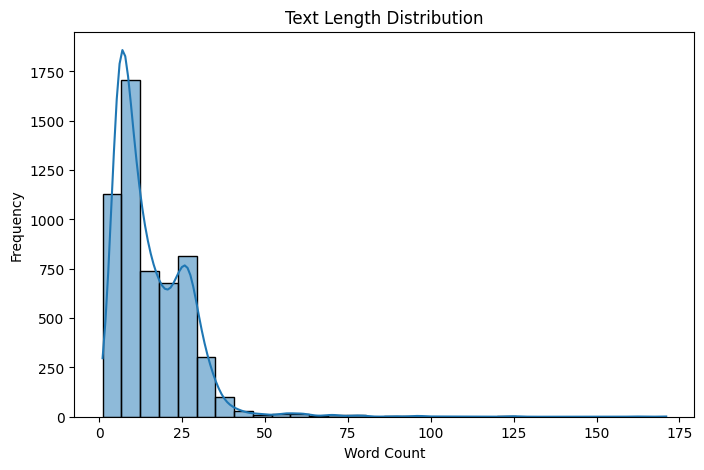

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.savefig('text_length_hist.png')
plt.show()


In [12]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label_encoded']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [14]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)


SVC(kernel='linear')

In [15]:
print("=== Naive Bayes Evaluation ===")
nb_pred = nb.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, nb_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, nb_pred, target_names=le.classes_))


=== Naive Bayes Evaluation ===
Accuracy: 0.9794

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



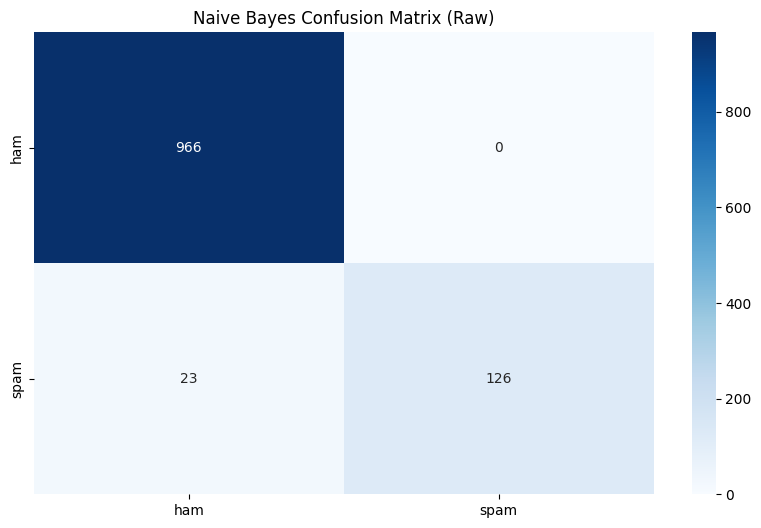

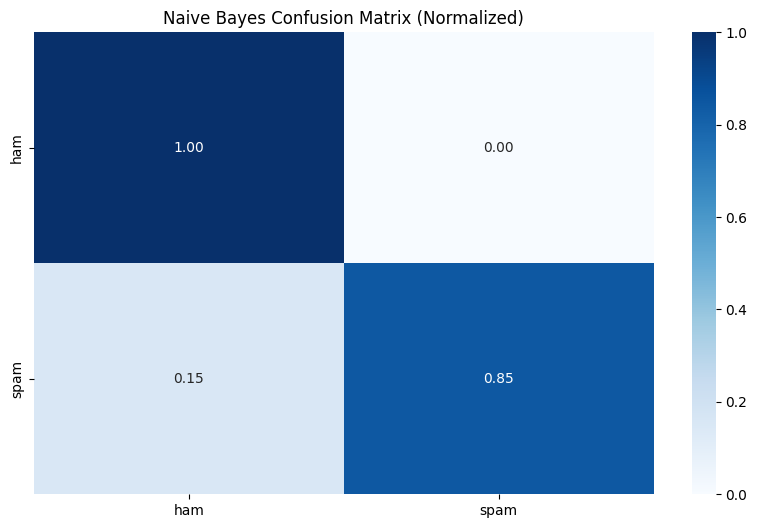

In [16]:
nb_cm = confusion_matrix(y_test, nb_pred)
nb_cm_norm = nb_cm.astype('float') / nb_cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,6))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Naive Bayes Confusion Matrix (Raw)")
plt.savefig('nb_cm_raw.png')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(nb_cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Naive Bayes Confusion Matrix (Normalized)")
plt.savefig('nb_cm_normalized.png')
plt.show()


In [17]:
print("=== SVM Evaluation ===")
svm_pred = svm.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, svm_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_pred, target_names=le.classes_))


=== SVM Evaluation ===
Accuracy: 0.9865

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.90      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



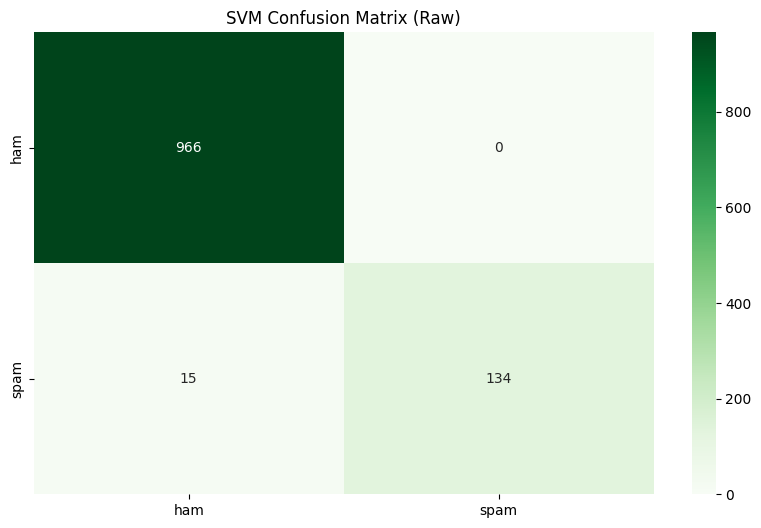

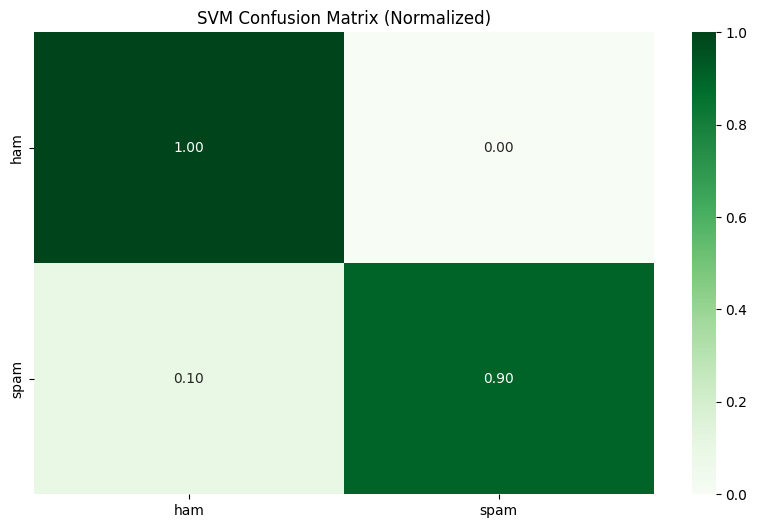

In [18]:
svm_cm = confusion_matrix(y_test, svm_pred)
svm_cm_norm = svm_cm.astype('float') / svm_cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("SVM Confusion Matrix (Raw)")
plt.savefig('svm_cm_raw.png')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(svm_cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("SVM Confusion Matrix (Normalized)")
plt.savefig('svm_cm_normalized.png')
plt.show()


In [19]:
nb_acc = accuracy_score(y_test, nb_pred)
svm_acc = accuracy_score(y_test, svm_pred)

print("\n=== Model Comparison ===")
print(f"Naive Bayes Accuracy: {nb_acc:.4f}")
print(f"SVM Accuracy: {svm_acc:.4f}")
print(f"Difference (SVM - NB): {(svm_acc - nb_acc):.4f}")



=== Model Comparison ===
Naive Bayes Accuracy: 0.9794
SVM Accuracy: 0.9865
Difference (SVM - NB): 0.0072


In [20]:
import joblib

joblib.dump(svm, 'svm_model.joblib')
joblib.dump(nb, 'nb_model.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(le, 'label_encoder.joblib')
print("Models and vectorizer saved.")


Models and vectorizer saved.
